In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Ejemplo numérico

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas y el objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$.

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_1u[k-1]+...+b_{n_b}u[k-{n_b}] + L + e[k]$$

Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[t] = \phi.\theta + e[t]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&...&u[k-{n_b}]&1\end{bmatrix}$$


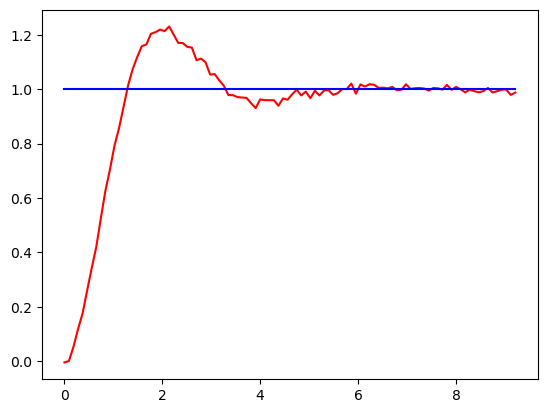

In [2]:
## Sistema de segundo orden en tiempo continuo
g = control.tf(6,[2,3,6])
t,y = control.step_response(g)
N = len(y)
u = np.ones(N);
dt = t[1]-t[0]


## Ruido para las señales
r = 0.01
e = np.random.normal(0,r,size=N)

yn = y+e

plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')

dt

## Definir la matriz de regresión
$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&...&u[k-{n_b}]\end{bmatrix}$$

In [5]:
## Definir y_1, y_2, y_3, dependiendo de su HIPÓTESIS
## del sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
    
## Creación de la hipótesis
phi = np.array([-y_1,-y_2,u_1,u_2,np.ones(N)]).transpose()

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$


La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad.

In [25]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0.945
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.4333015 , -0.38946019,  0.0466168 ,  0.11429126,  0.02027822])

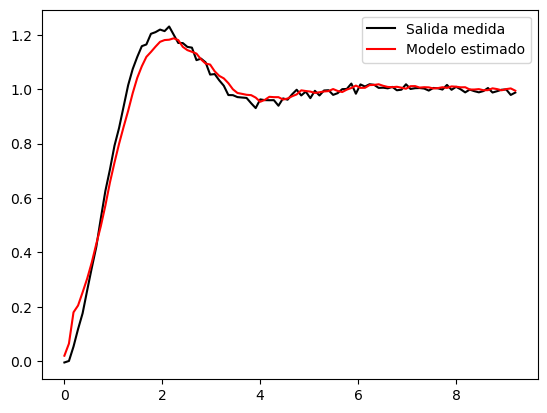

In [26]:
## SIn función de transferencia aún, podemos calcular los datos estimados
## Aplicando la ecuación del modelo ye = phi*theta
_ye = np.dot(phi,theta)
plt.plot(t,yn,color = 'black')
plt.plot(t,_ye,color = 'red')
plt.legend(['Salida medida','Modelo estimado'])

In [27]:
## Construyendo las funciones G y H    y(k) = G(z)u(k) + H(z)e(k)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)
## Construir los polinomios A(z) y B(z)
A = z**2 + theta[0]*z + theta[1]
B = theta[2]*z+theta[3]
G = B/A
G = G.simplify()
H = 1/A
H = H.simplify()
G, H


  0.04662 z + 0.1143
-----------------------
z^2 - 0.4333 z - 0.3895

dt = 0.09303374113107254



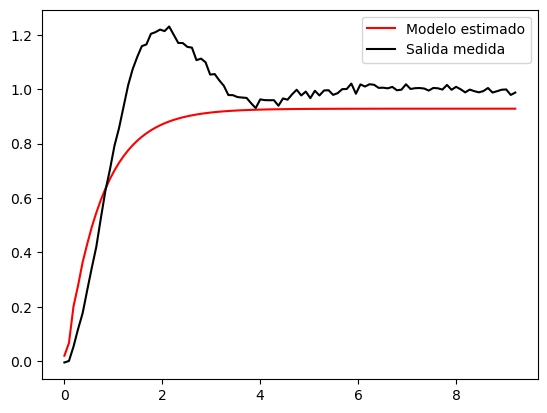

In [29]:
## Intento 1 - respuesta discreta.
## Ensayar con nuevos dt
G_e = control.tf([theta[2],theta[3]],[1,theta[0],theta[1]],dt)
#H_e = control.tf([1,0,0],[1,theta[0],theta[1]],dt)
Kf = 5
_,ye = control.step_response(G_e,t)

#ye = ye+theta[4];

plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])

ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)
## Función de transferencia G(z)
print(G_e)
ECM

In [22]:
## El ejercicio podría se usar la función estimada en tiempo discreto para
## Regresar a tiempo continuo

In [24]:
sys = control.ss(G_e)
Adis = sys.A
Bdis = sys.B
C = sys.C
D = sys.D
